In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import uproot 
import awkward as ak
from pathlib import Path

from typing import Dict, List 
import re
import pickle
from tqdm import tqdm

In [9]:
training_vars = ['jet_pt', 'jet_eta', 'jet_nTracks', 'jet_trackWidth', 'jet_trackC1']
all_vars = training_vars + ['total_weight', 'flatpt_weight']
n_jets = 2_000_000

In [4]:
sample_alljets_path = '../../samples/BDT_training/sample_2M_w_flatpt.pkl'
with open(sample_alljets_path, 'rb') as f:
    sample_2Mjets = pd.read_pickle(f)

In [13]:
X = sample_2Mjets.iloc[:, :-1]
y = sample_2Mjets.iloc[:, -1]

from sklearn.model_selection import train_test_split

X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=0.1, random_state=456)
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.1/0.9, random_state=789)


In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

dt = DecisionTreeClassifier(max_depth=9,
                            min_samples_leaf=0.001,
                            max_features="log2")
bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=1000,
                         learning_rate=0.1)

bdt.fit(X_train[training_vars], y_train, sample_weight=X_train['flatpt_weight'])


AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=9,
                                                         max_features='log2',
                                                         min_samples_leaf=0.001),
                   learning_rate=0.1, n_estimators=1000)

In [15]:
import pickle
filename = './BDT_5var_1M.model'
pickle.dump(bdt, open(filename, 'wb'))

In [16]:
y_test_decisions = bdt.decision_function(X_test[training_vars])

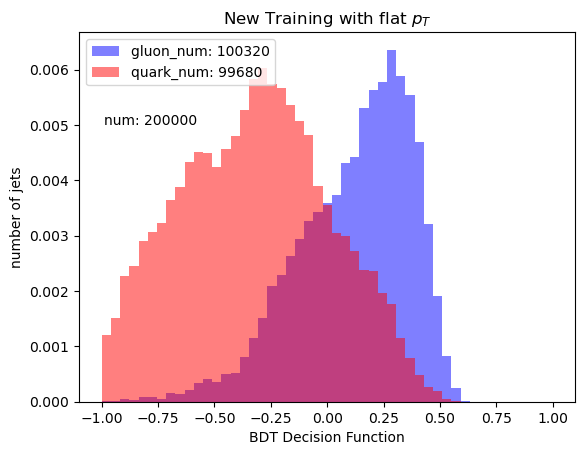

In [18]:
y_test_gluon_id = np.where(y_test==1)[0]
y_test_quark_id = np.where(y_test==0)[0]
bins_scores = np.linspace(-1, 1, 50)
plt.hist(y_test_decisions[y_test_gluon_id], weights=X_test.iloc[y_test_gluon_id, -1], bins= bins_scores, alpha=0.5, label='gluon'+f"_num: {len(y_test_gluon_id)}", color = 'blue') # add the weights! 
plt.hist(y_test_decisions[y_test_quark_id], weights=X_test.iloc[y_test_quark_id, -1], bins= bins_scores, alpha=0.5, label='quark'+f"_num: {len(y_test_quark_id)}", color = 'red')
plt.legend(loc='upper left')
plt.text(0.05, 0.75, f"num: {len(X_test)}", transform=plt.gca().transAxes)
plt.xlabel("BDT Decision Function")
plt.ylabel("number of jets")
plt.title(r"New Training with flat $p_{T}$")
plt.savefig("BDT_5var_1M.png", dpi=300)
plt.show()

In [21]:
from sklearn.metrics import roc_curve, auc

def Draw_ROC_all(y, decisions, y_tmva, y_ntrk, X_weight, features, file_name):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y, decisions, sample_weight = X_weight)
    fpr_tmva, tpr_tmva, thresholds_tmva = roc_curve(y, y_tmva, sample_weight = X_weight)
    fpr_ntrk, tpr_ntrk, thresholds_ntrk =  roc_curve(y, y_ntrk, sample_weight = X_weight)

    roc_auc = auc(fpr, tpr)
    roc_auc_tmva = auc(fpr_tmva, tpr_tmva)
    roc_auc_ntrk = auc(fpr_ntrk, tpr_ntrk)


    plt.plot(1-fpr, tpr, lw=1, label='ROC_NewTraining (area = %0.3f)'%(roc_auc))
    plt.plot(1-fpr_tmva, tpr_tmva, lw=1, label='ROC_TMVA (area = %0.3f)'%(roc_auc_tmva))
    plt.plot(1-fpr_ntrk, tpr_ntrk, lw=1, label='ROC_Ntrk (area = %0.3f)'%(roc_auc_ntrk))

    plt.plot([0, 1], [1, 0], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC with features:{features}'+r" flat $p_{T}$")
    plt.legend(loc="lower left")
    plt.grid()
    plt.savefig(file_name, dpi=300)

    plt.show()



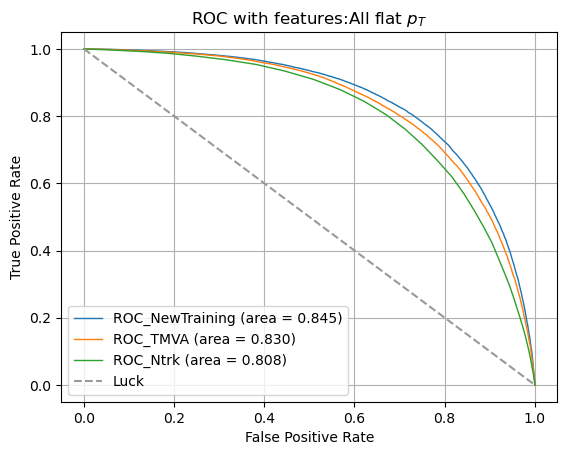

In [22]:
Draw_ROC_all(y_test, y_test_decisions, y_tmva=X_test['jet_trackBDT'] , y_ntrk=X_test['jet_nTracks'], X_weight=X_test['total_weight'], features="All", file_name = 'BDT_ROC_5var_1M')

# y_score in Pt bins

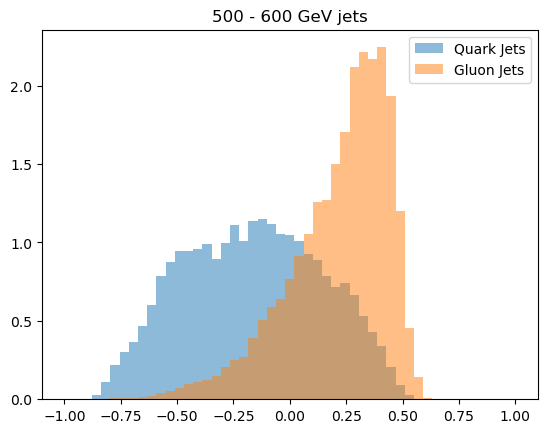

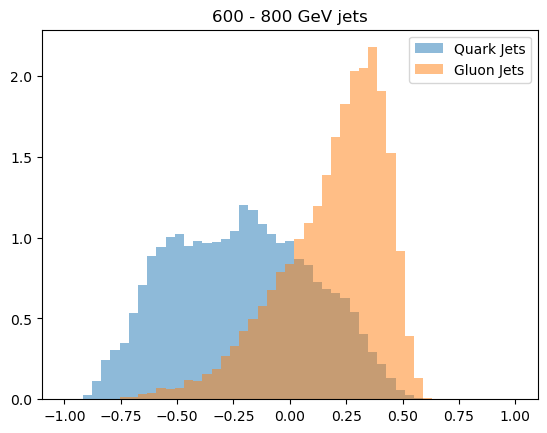

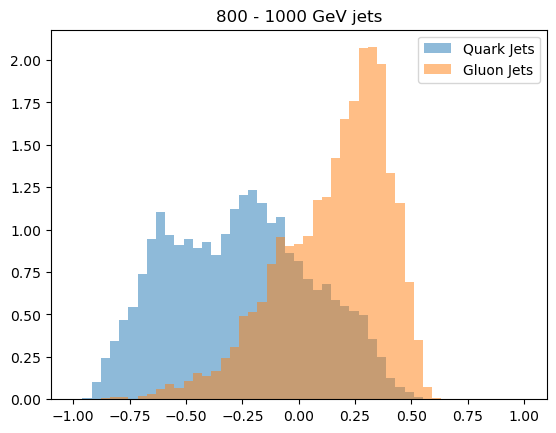

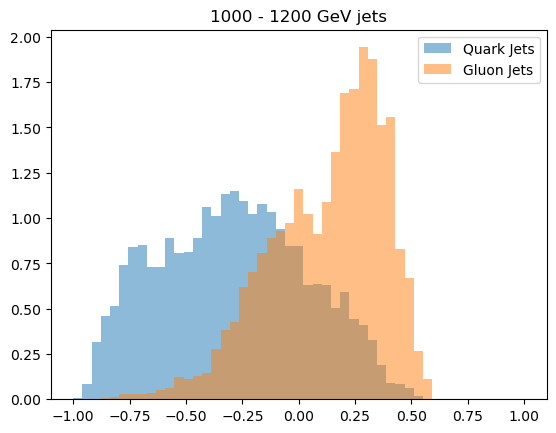

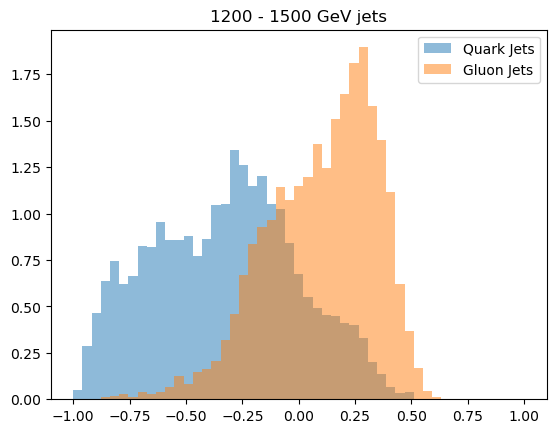

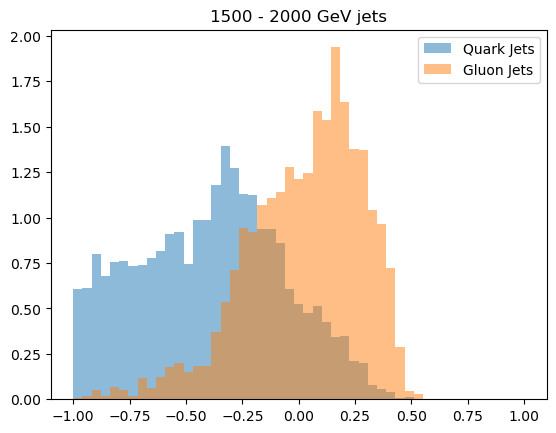

In [24]:
bdt_bins = np.linspace(-1, 1, 50)

label_ptrange = np.array([500, 600, 800, 1000, 1200, 1500, 2000])
pt_binned_jets_idx = np.digitize(X_test['jet_pt'], bins=label_ptrange)
for i, pt in enumerate(label_ptrange[:-1]):
    jets_at_pt_idx = np.where(pt_binned_jets_idx-1 == i)
    jets_at_pt = X_test.iloc[jets_at_pt_idx]
    y_test_at_pt = y_test.iloc[jets_at_pt_idx]
    gluon_idx = np.where(y_test_at_pt ==1)[0]
    quark_idx = np.where(y_test_at_pt ==0)[0]
    fig, ax = plt.subplots()
    
    ax.hist(y_test_decisions[jets_at_pt_idx][quark_idx], weights=jets_at_pt.iloc[quark_idx, -1], bins =  bdt_bins, alpha = 0.5, label='Quark Jets', density = True)
    ax.hist(y_test_decisions[jets_at_pt_idx][gluon_idx], weights=jets_at_pt.iloc[gluon_idx, -1], bins =  bdt_bins, alpha = 0.5, label='Gluon Jets', density = True)
    ax.legend()
    ax.set_title(f"{pt} - {label_ptrange[i+1]} GeV jets")
    plt.plot()